# Titanic - Data Egineering

This notebook details the pre-processing applied to the Titanic training data before  it is used to try to predict the survival of the Titanic passengers based on some personal and travelling details.

In the following the the next areas will be covered:
* Retriving data and looking at data information
* Features analysis and selection
* Dealing with missing values
* Creating new features
* Categorical variable encoding
* Saving pre-processed dataset

## Data retrieval and info

In [5]:
# Import required packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [6]:
# Read Titanic training data as a pandas dataframe
# Training Data
df_train = pd.read_csv(os.getcwd() + '/train.csv', na_values="?")



Now we take a quick look:

In [7]:
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


We can see that each passengers' id is provided together with the survival classification and a set of features for predicting the survival. According to the Kaggle's competition, here is a summary of the meaning of the variables:
* Pclass: passengers' travelling class
* Name: passengers' name
* Sex: passengers' gender
* Age: passengers' age (when value are defined with half a year this specifies that the value has been estimated)
* SibSp: number of sibilings or spouse the passengers are travelling with
* Parch: number of parents of childer the passengers are travelling with
* Ticket: ticket number of the passengers
* Fare: passengers' fare
* Cabin: Cabin number
* Embarked: Port of embarkation
(See: https://www.kaggle.com/c/titanic/data)

Next, a summary of the dataset info is display, showing the features' data types and amount of non-nan (or non-null) values in each feature

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Here are some observations:
* There are three features presenting missing values: 'Embarked', 'Age' and 'Cabin'. A strategy of dealing with missing values will be defined in following sections
* Some of the variables are categorical; they need to be converted to numerical to be interpreted by a ML algorithm

In the following section, the features will be analysed more in detail before dealing with missing data and feature encoding.

## Data analysis and feature selection

We will display the correlation matrix first to get a feel of the possible relation of th efeatures with the survival classification and potential correlation between the variables as well.

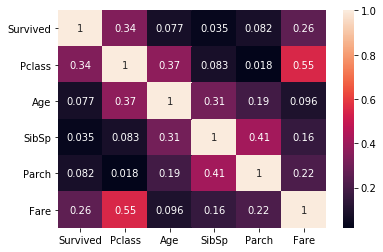

In [9]:
# Copying the training dataset before manipulation of the data
df = df_train.copy()

# Correlation matrix plot
features = df.columns[1:]
corrMatrix = df[features].corr()
sns.heatmap(abs(corrMatrix), annot=True)
plt.show()

There is no obvious correlation between the survival classification and the features; the highest correlation is given by 'Pclass'. 'Pclass' is also showing some sort of relationship with 'Fare', wich makes sense: travelling in a higher class should have been more expensive. 

In the following the relevance of each feature will be analysed.

### Pclass

The next graph shows the effect of 'Pclass' on survival. The percentage of passengers in 1st class who survived is higher than those who died. On the other hand, the percentage of passengers in 3rd class who died is significantly higher than that of those in the same class who lived. The percentage of passengers in 2nd class is small with barely any differences in survival.

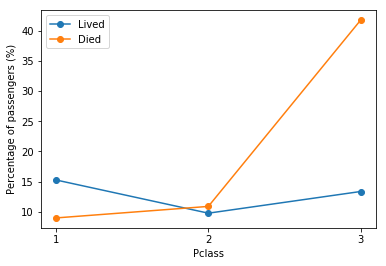

In [10]:
# Pclass feature relevance on survival
plt.plot(df['Pclass'].loc[df['Survived']==1].value_counts(sort=False)/len(df) * 100,'o-',label='Lived')
plt.plot(df['Pclass'].loc[df['Survived']==0].value_counts(sort=False)/len(df) * 100,'o-',label='Died')
plt.xticks([1,2,3])
plt.xlabel('Pclass')
plt.ylabel('Percentage of passengers (%)')
plt.legend()
plt.show()

### Sex

Similarly, the following graph shows how gender had an impact on survival: the percentage of male passengers who died is significantly higher than of those who lived; however, there was a greater number of women who survived.

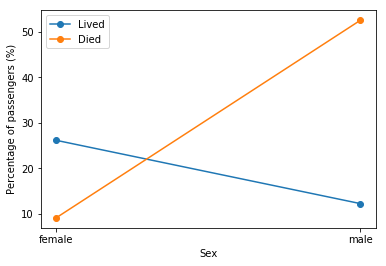

In [11]:
# Sex feature relevance on survival
plt.plot(df['Sex'].loc[df['Survived']==1].value_counts()/len(df) * 100,'o-',label='Lived')
plt.plot(df['Sex'].loc[df['Survived']==0].value_counts()/len(df) * 100,'o-',label='Died')
plt.xticks(['female','male'])
plt.xlabel('Sex')
plt.ylabel('Percentage of passengers (%)')
plt.legend()
plt.show()

### Age
The histograms below show that more children survived than not. Also, there is significantly more passengers from about 16 and 32 years old who died.  

C:\Users\Marina\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Marina\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


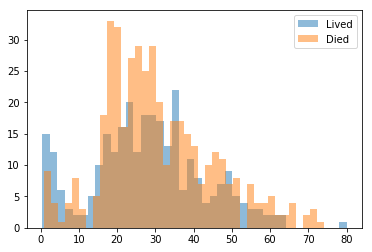

In [12]:
plt.hist(df['Age'].loc[df['Survived']==1], alpha=0.5, label='Lived', bins=40)
plt.hist(df['Age'].loc[df['Survived']==0], alpha=0.5, label='Died', bins=40)
plt.legend()
plt.show()

### SibSp

The next graph shows that a greater number of people travelling with no sibling + spouse died.
The amount of passengers dying or surviving with a number of siblings + spouse from 1 to 4 is the same.
Finally, all passengers with siblings + spouse higher than 4 died.

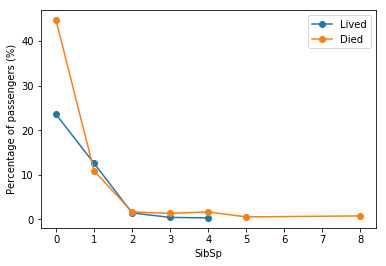

In [13]:
# SibSP feature relevance on survival
plt.plot(df['SibSp'].loc[df['Survived']==1].value_counts(sort=False)/len(df) * 100,'o-',label='Lived')
plt.plot(df['SibSp'].loc[df['Survived']==0].value_counts(sort=False)/len(df) * 100,'o-',label='Died')
plt.xlabel('SibSp')
plt.ylabel('Percentage of passengers (%)')
plt.legend()
plt.show()

### Parch
Similarly to 'SibSP', the main difference in survival appears for passengers travelling with no parents or children.

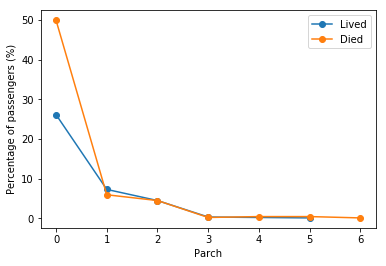

In [14]:
# SibSP feature relevance on survival
plt.plot(df['Parch'].loc[df['Survived']==1].value_counts(sort=False)/len(df) * 100,'o-',label='Lived')
plt.plot(df['Parch'].loc[df['Survived']==0].value_counts(sort=False)/len(df) * 100,'o-',label='Died')
plt.xlabel('Parch')
plt.ylabel('Percentage of passengers (%)')
plt.legend()
plt.show()

### Fare

As seen in the 'Pclass' feature, a greater number of passengers who paid a lower fare died. On the other hand, those who paid more expensive tickets lived. 

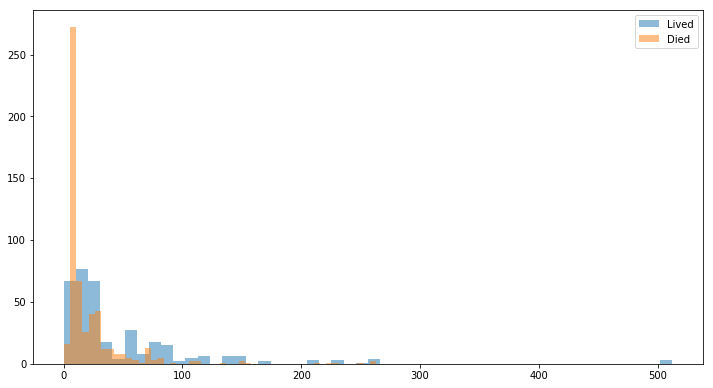

In [15]:
plt.figure(figsize=(12, 6.5))
plt.hist(df['Fare'].loc[df['Survived']==1], alpha=0.5, label='Lived', bins=50)
plt.hist(df['Fare'].loc[df['Survived']==0], alpha=0.5, label='Died', bins=50)
plt.legend()
plt.show()

### Name
This feature needs to be processed before any analysis can be done.
It is thought that the relevant information in this feature resides in the passengers title; thus, other name information is discarded. The uncommon titles are grouped.

The graph comparing the survival percentage relative to the passengers' title shows similar information 

In [16]:
# Keep only the names title; 
df['Title'] = df['Name'].str.split(',').str[1].str.split('.').str[0]
df['Title'].value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Major             2
 Col               2
 Mlle              2
 the Countess      1
 Sir               1
 Ms                1
 Don               1
 Jonkheer          1
 Mme               1
 Capt              1
 Lady              1
Name: Title, dtype: int64

In [17]:
# Group theh less common titles into the most common with the same meaning
df['Title'] = df['Title'].str.replace('Mlle','Miss')
df['Title'] = df['Title'].str.replace('Ms','Miss')
df['Title'] = df['Title'].str.replace('Mme','Mrs')
df['Title'] = df['Title'].str.replace('Col','Rank')
df['Title'] = df['Title'].str.replace('Major','Rank')

elite = ['Sir','Don','the Countess','Lady','Jonkheer']
for title in elite:
    df['Title'] = df['Title'].str.replace(title,'Elite')

#other_titles = ['Dr','Rev','Major','Col','Sir','the Countess','Don','Capt','Lady','Jonkheer']
#for title in other_titles:
 #   df['Name'] = df['Name'].str.replace(title,'Other')

df['Title'].value_counts()

 Mr        517
 Miss      185
 Mrs       126
 Master     40
 Dr          7
 Rev         6
 Elite       5
 Rank        4
 Capt        1
Name: Title, dtype: int64

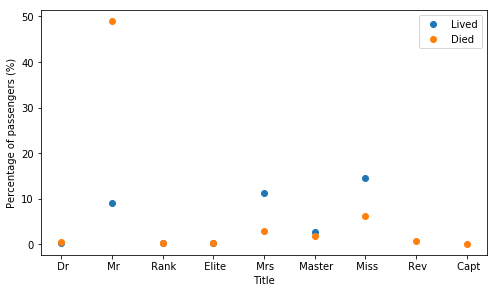

In [18]:
plt.figure(figsize=(8, 4.5))
plt.plot(df['Title'].loc[df['Survived']==1].value_counts(sort=False)/len(df) * 100,'o',label='Lived')
plt.plot(df['Title'].loc[df['Survived']==0].value_counts(sort=False)/len(df) * 100,'o',label='Died')
plt.xlabel('Title')
plt.ylabel('Percentage of passengers (%)')
plt.legend()
plt.show()

When looking at Miss, Mrs and Mr the same gender differences observed when analysing the 'Sex' feature are shown. The number of passengers with other titles is so small that differences in the percentage are not appreciated. The next graph show the percentage within each category in 'Name'

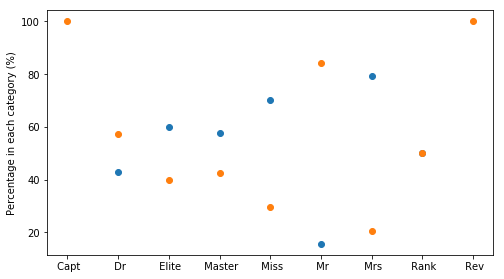

In [19]:
plt.figure(figsize=(8, 4.5))
plt.plot(df['Title'].loc[df['Survived']==1].value_counts()/df['Title'].value_counts() * 100, 'o', label='lived')
plt.plot(df['Title'].loc[df['Survived']==0].value_counts()/df['Title'].value_counts()* 100, 'o', label='died')
plt.ylabel('Percentage in each category (%)')
plt.show()

Now we can see that the Captain and all the reverends died; therefore, although the groups are small, they are kept as separate categories.

### Cabin

The percentages shown are very small due to the great amount of missing data.


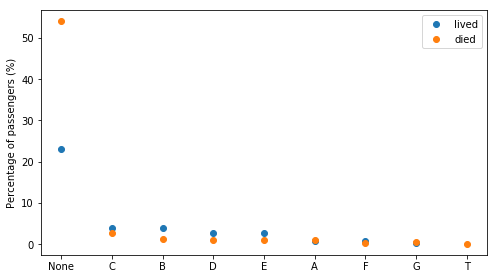

In [20]:
# Get letter of cabin
df['Cabin'] = df['Cabin'].str.replace('[^a-zA-Z]', '').str[-1]
df['Cabin'] = df['Cabin'].fillna('None')
df['Cabin'].value_counts()

plt.figure(figsize=(8, 4.5))
plt.plot(df['Cabin'].loc[df['Survived']==1].value_counts()/len(df) * 100, 'o', label='lived')
plt.plot(df['Cabin'].loc[df['Survived']==0].value_counts()/len(df) * 100, 'o', label='died')
plt.ylabel('Percentage of passengers (%)')
plt.legend()
plt.show()

### Embarked
The main difference in survival is seen for the passengers embarking in S: Southampton.
The majority of deaths correspond to passengers who embarked in this port;
however, most of the passengers did embark here; therefore, it appears that the difference seen is only due to a greater number of passengers dying overall.
Thus, this feature does not seem to bring any information about survival and could potentially be dropped.

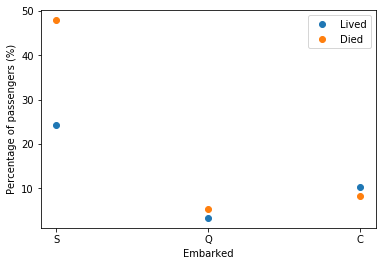

In [21]:
plt.plot(df['Embarked'].loc[df['Survived']==1].value_counts(sort=False)/len(df) * 100,'o',label='Lived')
plt.plot(df['Embarked'].loc[df['Survived']==0].value_counts(sort=False)/len(df) * 100,'o',label='Died')
plt.xlabel('Embarked')
plt.ylabel('Percentage of passengers (%)')
plt.legend()
plt.show()

### Ticket
If we focus only in the numerical part of the tickets and plot a histogram as show below, we can see that the numerical code is grouped around certain values:
* There is one set of tickets numbered at around 3.000.000
* If we take a closer look into the lower tickets numbering we can observe another four groups

When we look at the histograms with a split regarding survival we see that there are different trends depending on the numbering data. The ticket data can be then grouped in a new variable.

(1, 500000)

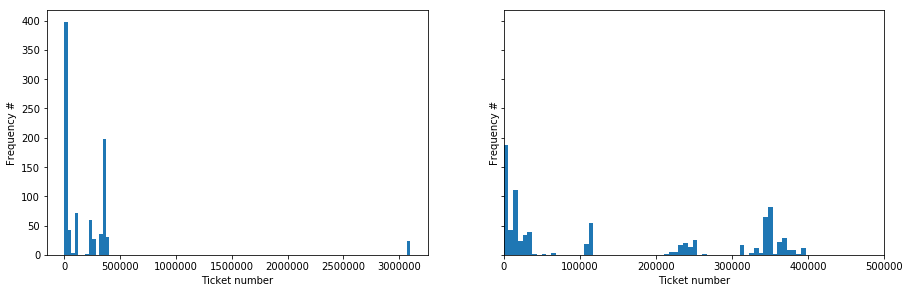

In [22]:
# Convert ticket feature to numerical values based on the numerical information only
df['Ticket'] = df['Ticket'].str.extract('(\d+)').fillna(0).astype('float')

# Plot histogram to view numbering distribution
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,4.5))
ax1.hist(np.array(df['Ticket']), bins=100)
ax1.set_ylabel('Frequency #')
ax1.set_xlabel('Ticket number')
ax2.hist(np.array(df['Ticket']), bins=500)
ax2.set_ylabel('Frequency #')
ax2.set_xlabel('Ticket number')
ax2.set_xlim(1,500000)

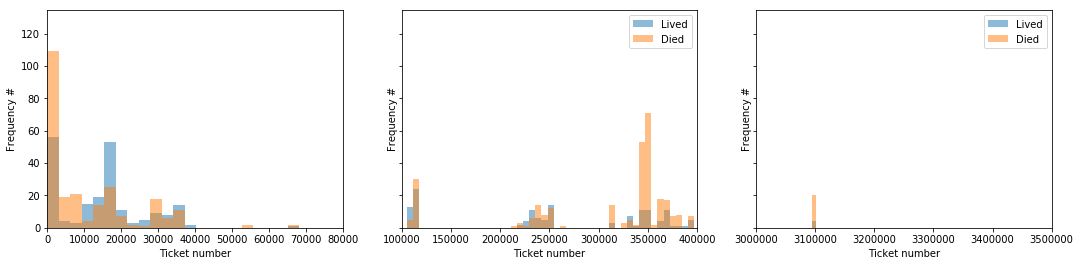

In [23]:
# Histogram with survival split
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(18,4))

ax1.hist(df['Ticket'].loc[df['Survived']==1], alpha=0.5, label='Lived', bins=1000)
ax1.hist(df['Ticket'].loc[df['Survived']==0], alpha=0.5, label='Died', bins=1000)
ax1.set_xlim(0,80000)
ax1.set_ylabel('Frequency #')
ax1.set_xlabel('Ticket number')

ax2.hist(df['Ticket'].loc[df['Survived']==1], alpha=0.5, label='Lived', bins=500)
ax2.hist(df['Ticket'].loc[df['Survived']==0], alpha=0.5, label='Died', bins=500)
ax2.set_xlim(100000,400000)
ax2.set_ylabel('Frequency #')
ax2.set_xlabel('Ticket number')
ax2.legend()

ax3.hist(df['Ticket'].loc[df['Survived']==1], alpha=0.5, label='Lived', bins=500)
ax3.hist(df['Ticket'].loc[df['Survived']==0], alpha=0.5, label='Died', bins=500)
ax3.set_xlim(3000000,3500000)
ax3.set_ylabel('Frequency #')
ax3.set_xlabel('Ticket number')
ax3.legend()


### Features selection

#### Variables to keep
* 'Pclass'
* 'Sex'
* 'Age'
* 'Name' transformed into 'Title'
* 'Cabin'
* 'Embarked' (consider dropping)
* 'Ticket', keeping only the numerical data

#### Features to create
* From 'SibSp' and 'Parch' a new variable counting the total number of companions can be derived
* Age groups divided by the observed relation of age and survival
* Fare groups
* Ticket groups

#### Features to drop
* 'SibSp' and 'Parch' would be redundant with the new variable created counting the total number of companions
* Full names in feature 'Name'



## Dealing with missing data

As shown in the previous section, there are two remaining variables containing missing data:

* Age: with nearly 20% of missing values. By intuition it seems that Age would be an important variable to consider, therefore the missing values would need to be replaced. The correlation of 'Age' with other variables will be analyse to try to replace missing values based on the values of those correlating variables
    
* Embarked: Very little missing values. This can~ be replaced by the most frequent value

* 'Ticket': missing values have been replaced by 0, however, it would be more suitable to replace those by the most frequent ticket value, since only very few values are missing

### Replace Age missing values

To understand how we can fill in the missing values it is important to see what is the relationship between the feature and other variables. This could help us build new values of Age based on other features' values if a correlation does exist. 

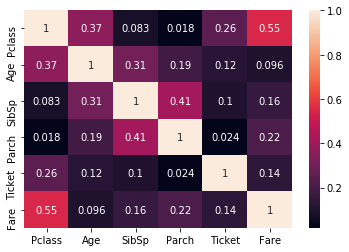

In [24]:
# Correlation matrix
import seaborn as sns

features = df.columns[2:]
corrMatrix = df[features].corr()
sns.heatmap(abs(corrMatrix), annot=True)
plt.show()

The highest correlation of 'Age' is with 'Pclass'.
‘Title’ might contain some age information as well.
The relationship of age with this two variables is investigated further in the following:

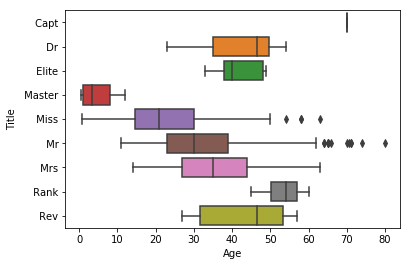

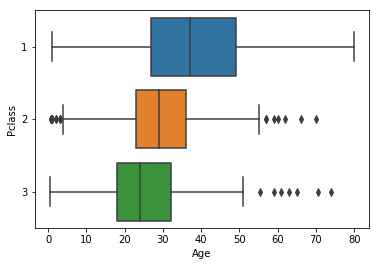

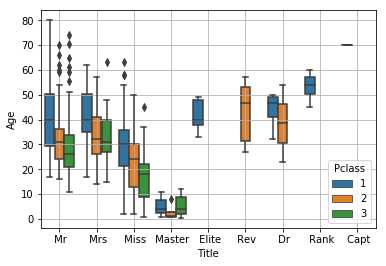

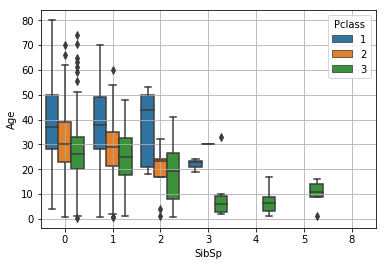

In [25]:
# Title boxplots by Pclass
sns.boxplot( y=pd.Categorical(df['Title']), x=df['Age'] )
plt.ylabel('Title')
plt.show()

sns.boxplot( y=pd.Categorical(df['Pclass']), x=df['Age'] )
plt.ylabel('Pclass')
plt.show()

# Age boxplots by SibSp comparing Pclass
sns.boxplot(x='Title', y='Age',
            hue='Pclass',#palette=["m", "g"],
            data=df)
plt.grid()
plt.show()

# Age boxplots by SibSp comparing Pclass
sns.boxplot(x='SibSp', y='Age',
            hue='Pclass',#palette=["m", "g"],
            data=df)
plt.grid()
plt.show()

There seem to be significant differences in the age range depending on the three features: 'Pclass', 'SibSp' and 'Title'.
The missing values in 'Age' are replaced by the grouped median values from common values of 'Pclass', 'SibSp' and 'Title' 

In [26]:
df['Age'] = df['Age'].fillna(df.groupby(["Pclass", "SibSp","Title"])['Age'].transform('median'))
print(df['Age'].isna().value_counts())

False    884
True       7
Name: Age, dtype: int64


There are still a few missing values. The grouped median is printed next to check where:

In [27]:
df.groupby(["Pclass", "SibSp","Title"])["Age"].median()

Pclass  SibSp  Title  
1       0       Dr        40.500
                Elite     38.000
                Master     4.000
                Miss      30.000
                Mr        40.000
                Mrs       48.000
                Rank      54.000
        1       Capt      70.000
                Elite     48.500
                Master     5.960
                Miss      32.000
                Mr        38.000
                Mrs       38.000
        2       Dr        47.000
                Miss      19.500
                Mrs       53.000
        3       Miss      23.500
                Mr        19.000
2       0       Dr        38.500
                Master     0.915
                Miss      27.000
                Mr        30.000
                Mrs       34.000
                Rev       42.000
        1       Master     2.500
                Miss       5.000
                Mr        32.250
                Mrs       29.000
                Rev       54.000
        2       Mast

The missing values in 'SibSp' = 8 are replaced by the median of the grouped age values for 'SibSp'=5, in 'Pclass'=3 and depending on the 'Title':

In [28]:
titles = df['Title'].loc[(df['Pclass']==3) & (df['SibSp']==5)].value_counts().index
for title in titles:
    new_age = df['Age'].loc[(df['Pclass']==3) & (df['SibSp']==5) & (df['Title']==title)].median()
    df.loc[np.isnan(df["Age"]) & (df['Title']==title) , 'Age'] = new_age

print(df['Age'].isna().value_counts())    

False    891
Name: Age, dtype: int64


### Replace Embarked missing values by most frequent value

In [29]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].value_counts().idxmax())

### Replace Ticket missing values by most frequent value
The missing values of the feature 'Ticket' were replaced by zeros in the previous section for plotting reasons. Thus, the missing values to be replaced are those equal to 0.

In [30]:
df['Ticket'].loc[df['Ticket']==0] = df['Ticket'].value_counts().idxmax()

C:\Users\Marina\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


The feature 'Age' has a smaller percentage of missing values; since this variable is thought to be important, the columns with missing values will not be removed; instead, the missing age values will be predicted 

## Creating new variables

### Age grouping

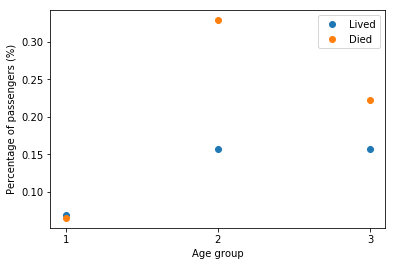

In [31]:
# Divide age in 3 groups
limit1 = 16
limit2 = 30
df['Age group'] = df['Age'].copy()
df['Age group'].loc[df['Age']<=limit1] = 1
df['Age group'].loc[(df['Age']>limit1) & (df['Age']<=limit2)] = 2
df['Age group'].loc[df['Age']>limit2] = 3
df['Age group'].value_counts()

# Plot survival percentages:
plt.plot(df['Age group'].loc[df['Survived']==1].value_counts(sort=False)/len(df),'o',label='Lived')
plt.plot(df['Age group'].loc[df['Survived']==0].value_counts(sort=False)/len(df),'o',label='Died')
plt.xticks([1,2,3])
plt.xlabel('Age group')
plt.ylabel('Percentage of passengers (%)')
plt.legend()
plt.show()

### Ticket grouping

From the histograms plotted in the previous section different fare groups are created:

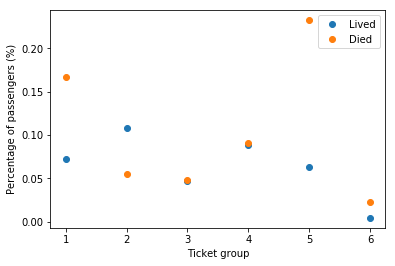

In [32]:
# Fare groups divided by 'Fare' data series quantiles 
df['Ticket group'] = df['Ticket'].copy()
df['Ticket group'].loc[df['Ticket']<=10000] = 1
df['Ticket group'].loc[(df['Ticket']>10000) & (df['Ticket']<=20000)] = 2
df['Ticket group'].loc[(df['Ticket']>20000) & (df['Ticket']<=100000)] = 3
df['Ticket group'].loc[(df['Ticket']>100000) & (df['Ticket']<=300000)] = 4
df['Ticket group'].loc[(df['Ticket']>300000) & (df['Ticket']<=3000000)] = 5
df['Ticket group'].loc[df['Ticket']>3000000] = 6
df['Ticket group'].value_counts()

# Plot survival percentages:
plt.plot(df['Ticket group'].loc[df['Survived']==1].value_counts(sort=False)/len(df),'o',label='Lived')
plt.plot(df['Ticket group'].loc[df['Survived']==0].value_counts(sort=False)/len(df),'o',label='Died')
plt.xlabel('Ticket group')
plt.ylabel('Percentage of passengers (%)')
plt.legend()
plt.show()

### Family relationships

Create a new column specifying if a person was travelling alone or accompained

In [33]:
# Create 'accompained' series with zeris values and replace 0 for the indexes corresponding to 'SibSp' or 'Parch' greater than 0
print(len(df['SibSp']))
accompained = pd.Series(np.zeros(len(df)))
accompained[df['SibSp'] > 0 ] = 1
accompained[df['Parch'] > 0 ] = 1
df['Accompanied'] = accompained

df[['SibSp','Parch','Accompanied','Age']].head(10)

891


,SibSp,Parch,Accompanied,Age
0,1,0,1.0,22.0
1,1,0,1.0,38.0
2,0,0,0.0,26.0
3,1,0,1.0,35.0
4,0,0,0.0,35.0
5,0,0,0.0,27.0
6,0,0,0.0,54.0
7,3,1,1.0,2.0
8,0,2,1.0,27.0
9,1,0,1.0,14.0


Create another variable with the number of people one is travelling with:

In [34]:
df['Companions'] = df['SibSp'] + df['Parch']

### Fare grouping

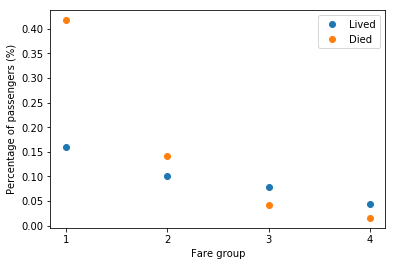

In [35]:
# Divide age in 3 groups
limit1 = 20
limit2 = 100
df['Fare group'] = df['Fare'].copy()
df['Fare group'].loc[df['Fare']<=20] = 1
df['Fare group'].loc[(df['Fare']>20) & (df['Fare']<=50)] = 2
df['Fare group'].loc[(df['Fare']>50) & (df['Fare']<=100)] = 3
df['Fare group'].loc[df['Fare']>100] = 4
df['Fare group'].value_counts()

# Plot survival percentages:
plt.plot(df['Fare group'].loc[df['Survived']==1].value_counts(sort=False)/len(df),'o',label='Lived')
plt.plot(df['Fare group'].loc[df['Survived']==0].value_counts(sort=False)/len(df),'o',label='Died')
plt.xticks([1,2,3,4])
plt.xlabel('Fare group')
plt.ylabel('Percentage of passengers (%)')
plt.legend()
plt.show()

### Fare per passenger

Let's look at the feature 'Fare' in relation to the number of companions and the passengers' class 'Pclass' to find out if the fare relates to the cabin price or to the price payed by each passenger

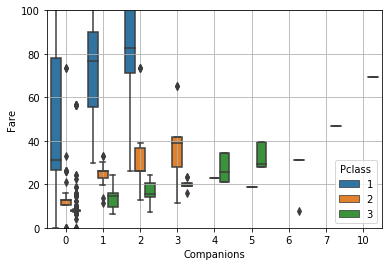

In [36]:
# Data distribution in Boxplots 
sns.boxplot(x='Companions', y='Fare',
            hue='Pclass',
            data=df)
plt.grid()
plt.ylim(0,100)
plt.show()

It looks like the fair increases with an increasing number of companions. This indicates that the fare is related to the price paid for the cabin and not per passenger. Thus, another feature can be created for the fare per passenger

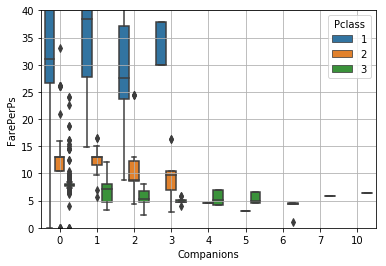

In [37]:
#df['Ncabins'] = df['Cabin'].str.replace('[^a-zA-Z]', '').str.len()
df['FarePerPs'] = df['Fare'] / (df['Companions']+1) #/df['Ncabins']

# Data distribution in Boxplots 
sns.boxplot(x='Companions', y='FarePerPs',
            hue='Pclass',
            data=df)
plt.grid()
plt.ylim(0,40)
plt.show()

In the new boxplots regarding the fare per passenger have more even fares regardless of the amount of companions

### Age data provided
Create another feature of binary values: 0 for age values provided and 1 for age values missing

In [38]:
df['Age_data'] = df_train['Age'].copy()
df['Age_data'].loc[df['Age_data'].notnull()] = 1
df['Age_data'].loc[df['Age_data'].isnull()] = 0
df['Age_data'].value_counts()

1.0    714
0.0    177
Name: Age_data, dtype: int64

## Dropping unnecessary features

In [39]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age group,Ticket group,Accompanied,Companions,Fare group,FarePerPs,Age_data
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,5.0,7.2500,None,S,Mr,2.0,1.0,1.0,1,1.0,3.62500,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,17599.0,71.2833,C,C,Mrs,3.0,2.0,1.0,1,3.0,35.64165,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,2.0,7.9250,None,S,Miss,2.0,1.0,0.0,0,1.0,7.92500,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803.0,53.1000,C,S,Mrs,3.0,4.0,1.0,1,3.0,26.55000,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450.0,8.0500,None,S,Mr,3.0,5.0,0.0,0,1.0,8.05000,1.0


In [40]:
df = df.drop(['Name', 'SibSp', 'Parch'], axis=1).copy()
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Age group,Ticket group,Accompanied,Companions,Fare group,FarePerPs,Age_data
0,1,0,3,male,22.0,5.0,7.2500,None,S,Mr,2.0,1.0,1.0,1,1.0,3.62500,1.0
1,2,1,1,female,38.0,17599.0,71.2833,C,C,Mrs,3.0,2.0,1.0,1,3.0,35.64165,1.0
2,3,1,3,female,26.0,2.0,7.9250,None,S,Miss,2.0,1.0,0.0,0,1.0,7.92500,1.0
3,4,1,1,female,35.0,113803.0,53.1000,C,S,Mrs,3.0,4.0,1.0,1,3.0,26.55000,1.0
4,5,0,3,male,35.0,373450.0,8.0500,None,S,Mr,3.0,5.0,0.0,0,1.0,8.05000,1.0


## Encoding categorical variables
The remaining categorical variables into numerical data to be interpreted by a ML algorithm.

In [41]:
# Defining a funtion to convert categorical data into numerical
def ConvertCategoricalData(df):
    s = (df.dtypes == 'object')
    categorical_cols = list(s[s].index)           
    le = LabelEncoder()
    df[categorical_cols] = df[categorical_cols].apply(lambda series: pd.Series(
        LabelEncoder().fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    ))
    return df.copy()


# Converting categorical variables
df = ConvertCategoricalData(df)

# Visualise converted data set
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Age group,Ticket group,Accompanied,Companions,Fare group,FarePerPs,Age_data
0,1,0,3,1,22.0,5.0,7.2500,7,2,5,2.0,1.0,1.0,1,1.0,3.62500,1.0
1,2,1,1,0,38.0,17599.0,71.2833,2,0,6,3.0,2.0,1.0,1,3.0,35.64165,1.0
2,3,1,3,0,26.0,2.0,7.9250,7,2,4,2.0,1.0,0.0,0,1.0,7.92500,1.0
3,4,1,1,0,35.0,113803.0,53.1000,2,2,6,3.0,4.0,1.0,1,3.0,26.55000,1.0
4,5,0,3,1,35.0,373450.0,8.0500,7,2,5,3.0,5.0,0.0,0,1.0,8.05000,1.0


## Save clean dataframe

In [42]:
# Convert all features to float
df = df.astype('float').copy()

# Save clean dataframe into a .csv file
df.to_csv("Clean_Titanic_train_dataframe.csv", index=False)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Age group,Ticket group,Accompanied,Companions,Fare group,FarePerPs,Age_data
0,1.0,0.0,3.0,1.0,22.0,5.0,7.2500,7.0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,3.62500,1.0
1,2.0,1.0,1.0,0.0,38.0,17599.0,71.2833,2.0,0.0,6.0,3.0,2.0,1.0,1.0,3.0,35.64165,1.0
2,3.0,1.0,3.0,0.0,26.0,2.0,7.9250,7.0,2.0,4.0,2.0,1.0,0.0,0.0,1.0,7.92500,1.0
3,4.0,1.0,1.0,0.0,35.0,113803.0,53.1000,2.0,2.0,6.0,3.0,4.0,1.0,1.0,3.0,26.55000,1.0
4,5.0,0.0,3.0,1.0,35.0,373450.0,8.0500,7.0,2.0,5.0,3.0,5.0,0.0,0.0,1.0,8.05000,1.0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
PassengerId     891 non-null float64
Survived        891 non-null float64
Pclass          891 non-null float64
Sex             891 non-null float64
Age             891 non-null float64
Ticket          891 non-null float64
Fare            891 non-null float64
Cabin           891 non-null float64
Embarked        891 non-null float64
Title           891 non-null float64
Age group       891 non-null float64
Ticket group    891 non-null float64
Accompanied     891 non-null float64
Companions      891 non-null float64
Fare group      891 non-null float64
FarePerPs       891 non-null float64
Age_data        891 non-null float64
dtypes: float64(17)
memory usage: 118.4 KB
